# Exploration of Butterworth Filters

In [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8311494/) paper, the network consists of two CNN modules that capture features from different perspectives. CNN with small filter sizes and strides is in charge of extracting detailed features and high-frequency information. On the contrary, CNN with larger sizes and strides is to capture low-frequency information, such as sleep waves.

In order to boost the classification accuracy, we will experiment with applying butterworth filters for low and high pass.

In [83]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data

In [84]:
from typing import List
ALICE, BOB = 0, 1
ANNOTATION_DESC_2_EVENT_ID = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

EVENT_ID = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

def fetch_epochs(subjects: List[int]) -> List[mne.Epochs]:
    user_files = fetch_data(subjects=subjects, recording=[1])
    epochs_list: List[mne.Epochs] = []
    for user_file in user_files:
        raw = mne.io.read_raw_edf(user_file[0], stim_channel='Event marker',
                                        misc=['Temp rectal'])
        annot = mne.read_annotations(user_file[1])
        raw.set_annotations(annot, emit_warning=True)
        # keep last 30-min wake events before sleep and first 30-min wake events after
        # sleep and redefine annotations on raw data
        annot.crop(annot[1]['onset'] - 30 * 60,
                        annot[-2]['onset'] + 30 * 60)
        raw.set_annotations(annot, emit_warning=False)
        events, _ = mne.events_from_annotations(
            raw, event_id=ANNOTATION_DESC_2_EVENT_ID, chunk_duration=30.)
        
        tmax = 30. - 1. / raw.info['sfreq']  # tmax in included

        epochs = mne.Epochs(raw=raw, events=events,
                                event_id=EVENT_ID, tmin=0., tmax=tmax, baseline=None)
        epochs_list.append(epochs)
    return epochs_list



In [91]:
[epochs_train, epochs_test] = fetch_epochs([ALICE, BOB])
# epochs.shape = (n_epochs, n_channels, n_times)
# n_ephochs = the number of 30-second epochs in the data
# n_channels = the number of channesl (e.g. EEG, EOG, EMG)
# n_times = the number of time points in each epoch

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /home/derek/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_6688/2681637432.py:23: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /home/derek/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_6688/2681637432.py:23: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated


Loading data for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 188 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 109 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Av

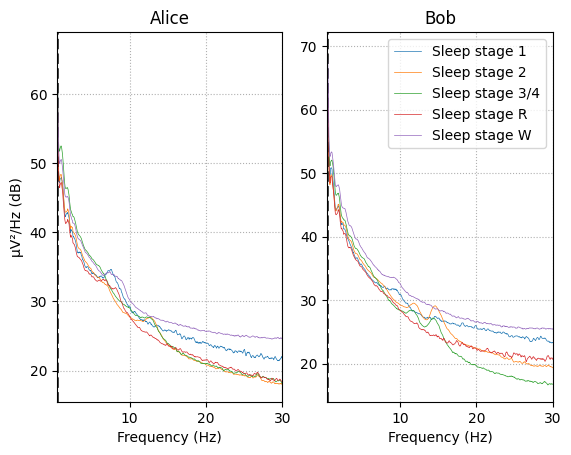

In [86]:
# visualize Alice vs. Bob PSD by sleep stage.
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
stages = sorted(EVENT_ID.keys())
for ax, title, epochs in zip([ax1, ax2],
                             ['Alice', 'Bob'],
                             [epochs_train, epochs_test]):

    for stage, color in zip(stages, stage_colors):
        spectrum = epochs[stage].compute_psd(picks='eeg', fmin=0.5, fmax=30.)
        spectrum.plot(ci=None, color=color, axes=ax,
                      show=False, average=True, spatial_colors=False)
    ax.set(title=title, xlabel='Frequency (Hz)')
ax1.set(ylabel='µV²/Hz (dB)')
ax2.legend(ax2.lines[2::3], stages)
plt.show()

In [87]:
from sklearn.preprocessing import FunctionTransformer

def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}
    # picks limits the channels to only eeg ones
    # fmin and fmax define the frequency range of interest
    # epochs.shape = (n_epochs, n_channels, n_times)
    spectrum = epochs.compute_psd(picks='eeg', fmin=0.5, fmax=30.)
    # spectrum.shape = (n_epochs, n_channels - (non eeg chanels), n_freqs)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # psds.shape = spectrum.shap, freqs.shape = (n_freqs,)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

funct_transformer = FunctionTransformer(eeg_power_band, validate=False)

In [89]:
X = funct_transformer.transform(epochs_train.copy())
print(X.shape)

Loading data for 841 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
(841, 25)
